In [1]:
import pandas as pd
import re
import numpy as np
import warnings

warnings.filterwarnings('ignore')


In [2]:
data = pd.read_csv('../2_data_preparation/filtered_fighters.csv')
data.rename(columns=lambda x: x.rstrip(':'), inplace=True)
data.columns = data.columns.str.lower()

In [3]:
data.drop(columns='url', inplace=True)
data.drop(data.columns[11], axis=1, inplace=True)
data

,name,record,height,weight,reach,stance,dob,slpm,str. acc.,sapm,str. def,td avg.,td acc.,td def.,sub. avg.
0,Lerone Murphy,Record: 14-0-1,"5' 9""",145 lbs.,"73""",Orthodox,"Jul 22, 1991",5.01,54%,2.60,60%,1.59,52%,46%,0.6
1,Edson Barboza,Record: 24-12-0,"5' 11""",145 lbs.,"75""",Orthodox,"Jan 21, 1986",4.11,44%,4.65,56%,0.45,50%,72%,0.1
2,Khaos Williams,Record: 15-3-0,"6' 0""",170 lbs.,"77""",Orthodox,"Mar 30, 1994",5.81,39%,5.42,42%,0.00,0%,80%,0.0
3,Carlston Harris,Record: 19-6-0,"6' 0""",170 lbs.,"76""",Orthodox,"Jul 09, 1987",3.18,49%,2.66,52%,1.97,29%,55%,0.8
4,Themba Gorimbo,Record: 13-4-0,"6' 1""",170 lbs.,"77""",Orthodox,"Jan 23, 1991",2.53,69%,1.08,46%,4.04,58%,78%,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2391,Nick Sanzo,Record: 1-1-0,"5' 9""",190 lbs.,--,NaN,--,0.00,0%,0.00,0%,0.00,0%,0%,0.0
2392,Jim Mullen,Record: 0-2-0,"6' 1""",215 lbs.,--,Southpaw,--,0.00,0%,0.00,0%,0.00,0%,0%,0.0
2393,Yoshiki Takahashi,Record: 30-27-3 (1 NC),"5' 11""",199 lbs.,--,Southpaw,"Mar 13, 1969",2.26,51%,6.47,44%,0.00,0%,66%,2.3
2394,Wallid Ismail,Record: 9-3-0,"5' 7""",205 lbs.,--,Orthodox,"Feb 23, 1968",0.92,31%,0.83,44%,1.85,28%,0%,0.5


In [4]:
# Convert to centimeters
def inches_to_cm(height_str):
    # Use regular expression to extract feet and inches
    match = re.match(r"(\d+)\'\s*(\d+)\"|(\d+)\"", height_str)
    if match:
        feet = int(match.group(1)) if match.group(1) else 0
        inches = int(match.group(2)) if match.group(2) else int(match.group(3))
        total_inches = feet * 12 + inches
        return total_inches * 2.54
    else:
        return None

In [5]:
data['height'] = data['height'].apply(inches_to_cm)
data['reach'] = data['reach'].apply(inches_to_cm)

In [6]:
def pounds_to_kg(weight_str):
    # Split the string into numeric value and unit
    weight_value, unit = weight_str.split()
    
    # Convert the numeric value to float and pounds to kilograms
    weight_kg = float(weight_value) * 0.453592
    
    return round(weight_kg, 2)

data['weight'] = data['weight'].apply(pounds_to_kg)

In [7]:
# fill reach f2
from sklearn.linear_model import LinearRegression
reach_data = data[['height','reach']].copy()
pred_data = reach_data[reach_data['reach'].isna()]

# Split data into training and prediction sets
train_data = reach_data.dropna()
f2_data = data[['height', 'reach']].copy()

# Train the linear regression model
X_train = train_data[['height']]
y_train = train_data['reach']

model = LinearRegression()
model.fit(X_train, y_train)

# Predict missing values
X_pred = pred_data[['height']]
pred_values = model.predict(X_pred)

# Replace missing values with predicted values
data.loc[data['reach'].isna(), 'reach'] = pred_values

In [8]:
data['stance'].fillna(data['stance'].mode()[0], inplace=True)

In [9]:
data = data.round(2)
data.columns

Index(['name', 'record', 'height', 'weight', 'reach', 'stance', 'dob', 'slpm',
       'str. acc.', 'sapm', 'str. def', 'td avg.', 'td acc.', 'td def.',
       'sub. avg.'],
      dtype='object')

In [10]:
cluster_data = data[['height', 'weight', 'reach', 'stance','slpm',
       'str. acc.', 'sapm', 'str. def', 'td avg.', 'td acc.', 'td def.',
       'sub. avg.']]

In [11]:
cluster_data

,height,weight,reach,stance,slpm,str. acc.,sapm,str. def,td avg.,td acc.,td def.,sub. avg.
0,175.26,65.77,185.42,Orthodox,5.01,54%,2.60,60%,1.59,52%,46%,0.6
1,180.34,65.77,190.50,Orthodox,4.11,44%,4.65,56%,0.45,50%,72%,0.1
2,182.88,77.11,195.58,Orthodox,5.81,39%,5.42,42%,0.00,0%,80%,0.0
3,182.88,77.11,193.04,Orthodox,3.18,49%,2.66,52%,1.97,29%,55%,0.8
4,185.42,77.11,195.58,Orthodox,2.53,69%,1.08,46%,4.04,58%,78%,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2391,175.26,86.18,179.55,Orthodox,0.00,0%,0.00,0%,0.00,0%,0%,0.0
2392,185.42,97.52,190.29,Southpaw,0.00,0%,0.00,0%,0.00,0%,0%,0.0
2393,180.34,90.26,184.92,Southpaw,2.26,51%,6.47,44%,0.00,0%,66%,2.3
2394,170.18,92.99,174.18,Orthodox,0.92,31%,0.83,44%,1.85,28%,0%,0.5


In [12]:
data['stance'] = data['stance'].replace(['Southpaw', 'Switch', 'Open Stance', 'Sideways'], 'Unorthodox')
data['stance'].value_counts()

stance
Orthodox      1843
Unorthodox     553
Name: count, dtype: int64

In [13]:
# convert percentage 
columns_to_process = ['str. acc.', 'str. def', 'td acc.', 'td def.']

for column in columns_to_process:
    data.loc[:, column] = cluster_data[column].str.rstrip('%').astype(int)
    new_column_name = column.replace('.', '_') + '_%'
    data.rename(columns={column: new_column_name}, inplace=True)


In [14]:
data.columns

Index(['name', 'record', 'height', 'weight', 'reach', 'stance', 'dob', 'slpm',
       'str_ acc__%', 'sapm', 'str_ def_%', 'td avg.', 'td acc__%',
       'td def__%', 'sub. avg.'],
      dtype='object')

In [15]:
cluster_data = data[['height', 'weight', 'reach', 'slpm',
       'str_ acc__%', 'sapm', 'str_ def_%', 'td avg.', 'td acc__%',
       'td def__%', 'sub. avg.', 'stance']]
cluster_data

,height,weight,reach,slpm,str_ acc__%,sapm,str_ def_%,td avg.,td acc__%,td def__%,sub. avg.,stance
0,175.26,65.77,185.42,5.01,54,2.60,60,1.59,52,46,0.6,Orthodox
1,180.34,65.77,190.50,4.11,44,4.65,56,0.45,50,72,0.1,Orthodox
2,182.88,77.11,195.58,5.81,39,5.42,42,0.00,0,80,0.0,Orthodox
3,182.88,77.11,193.04,3.18,49,2.66,52,1.97,29,55,0.8,Orthodox
4,185.42,77.11,195.58,2.53,69,1.08,46,4.04,58,78,0.0,Orthodox
...,...,...,...,...,...,...,...,...,...,...,...,...
2391,175.26,86.18,179.55,0.00,0,0.00,0,0.00,0,0,0.0,Orthodox
2392,185.42,97.52,190.29,0.00,0,0.00,0,0.00,0,0,0.0,Unorthodox
2393,180.34,90.26,184.92,2.26,51,6.47,44,0.00,0,66,2.3,Unorthodox
2394,170.18,92.99,174.18,0.92,31,0.83,44,1.85,28,0,0.5,Orthodox


In [18]:
cluster_data.drop(columns=['height', 'weight'], inplace=True)
cluster_data['str_ acc__%'] = pd.to_numeric(cluster_data['str_ acc__%'], errors='coerce')
cluster_data['str_ def_%'] = pd.to_numeric(cluster_data['str_ def_%'], errors='coerce')
cluster_data['td acc__%'] = pd.to_numeric(cluster_data['td acc__%'], errors='coerce')
cluster_data['td def__%'] = pd.to_numeric(cluster_data['td def__%'], errors='coerce')
cluster_data.dtypes

reach          float64
slpm           float64
str_ acc__%      int64
sapm           float64
str_ def_%       int64
td avg.        float64
td acc__%        int64
td def__%        int64
sub. avg.      float64
stance          object
dtype: object

In [19]:
# cluster data 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score

# Load your dataset
df = cluster_data

# Preprocessing
# Perform one-hot encoding for the categorical feature
df = pd.get_dummies(df, columns=['stance'], drop_first=True)

# Separate numerical features for scaling
numerical_features = df.select_dtypes(include=['float64', 'int64']).columns
X_numerical = df[numerical_features]

# Scale numerical features
scaler = StandardScaler()
scaled_numerical = scaler.fit_transform(X_numerical)

# Combine scaled numerical features with encoded categorical features
preprocessed_data = pd.concat([pd.DataFrame(scaled_numerical, columns=numerical_features), df.drop(columns=numerical_features)], axis=1)

In [20]:
preprocessed_data

,reach,slpm,str_ acc__%,sapm,str_ def_%,td avg.,td acc__%,td def__%,sub. avg.,stance_Unorthodox
0,0.267833,1.233601,0.899580,-0.469087,0.694656,0.096627,0.726696,-0.189241,-0.026788,False
1,0.761653,0.672021,0.140291,0.580145,0.396498,-0.669103,0.647859,0.718021,-0.468823,False
2,1.255474,1.732783,-0.239353,0.974246,-0.647058,-0.971365,-1.323077,0.997179,-0.557230,False
3,1.008564,0.091722,0.519935,-0.438377,0.098339,0.351871,-0.179934,0.124811,0.150026,False
4,1.255474,-0.313864,2.038513,-1.247053,-0.348899,1.742276,0.963209,0.927390,-0.557230,False
...,...,...,...,...,...,...,...,...,...,...
2391,-0.302782,-1.892528,-3.200580,-1.799819,-3.777725,-0.971365,-1.323077,-1.794398,-0.557230,False
2392,0.741240,-1.892528,-3.200580,-1.799819,-3.777725,-0.971365,-1.323077,-1.794398,-0.557230,True
2393,0.219229,-0.482338,0.671793,1.511657,-0.497979,-0.971365,-1.323077,0.508653,1.476133,True
2394,-0.824793,-1.318468,-0.846784,-1.375008,-0.497979,0.271268,-0.219353,-1.794398,-0.115195,False


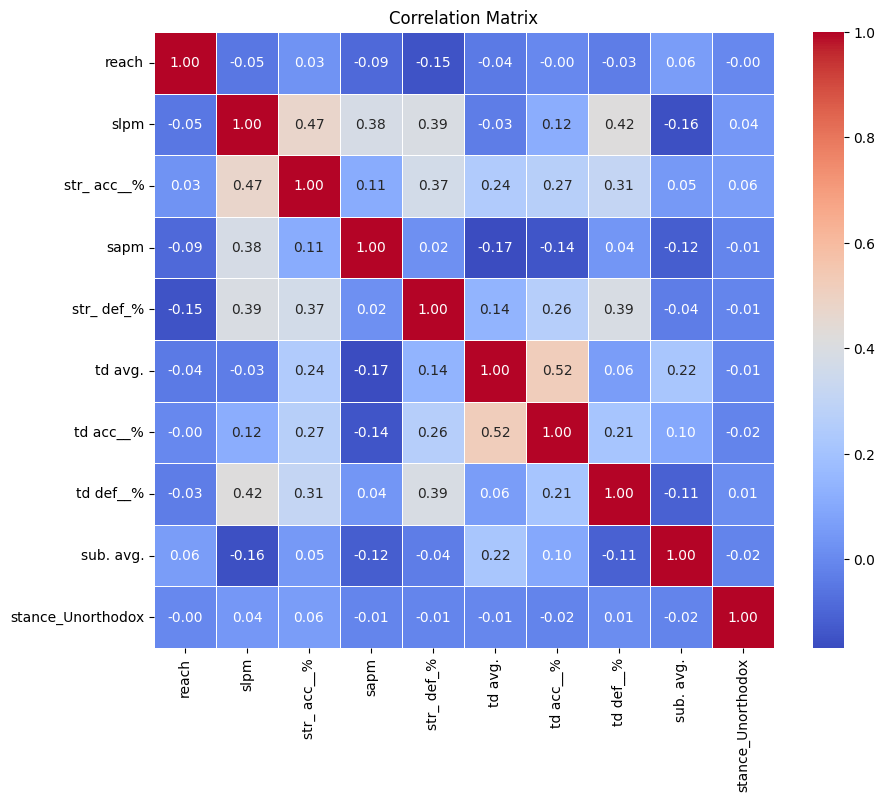

In [21]:
# Compute pairwise correlation
correlation_matrix = df.corr()

# Visualize correlation matrix using a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix")
plt.show()

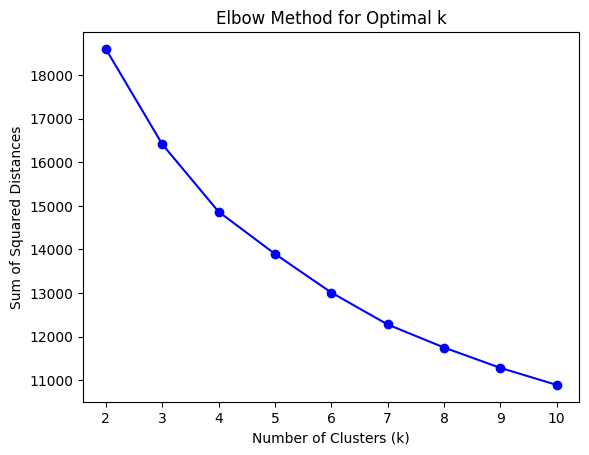

In [24]:
#
# Load your dataset
df = cluster_data

# Preprocessing
# Perform one-hot encoding for the categorical feature
df = pd.get_dummies(df, columns=['stance'], drop_first=True)

# Separate numerical features for scaling
numerical_features = df.select_dtypes(include=['float64', 'int64']).columns
X_numerical = df[numerical_features]

# Scale numerical features
scaler = StandardScaler()
scaled_numerical = scaler.fit_transform(X_numerical)

# Combine scaled numerical features with encoded categorical features
preprocessed_data = pd.concat([pd.DataFrame(scaled_numerical, columns=numerical_features), df.drop(columns=numerical_features)], axis=1)

# Define range of clusters to try
k_range = range(2, 11)  # Try k from 2 to 10

# Calculate sum of squared distances for each k
ssd = []
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(preprocessed_data)
    ssd.append(kmeans.inertia_)

# Plot the Elbow Method
plt.plot(k_range, ssd, 'bo-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Sum of Squared Distances')
plt.title('Elbow Method for Optimal k')
plt.show()

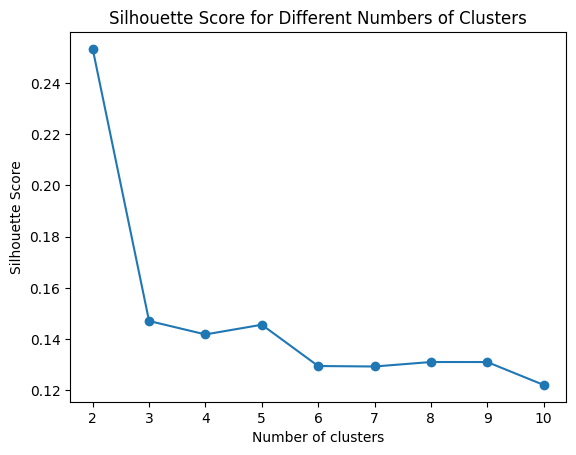

In [25]:
# Calculate silhouette score for different numbers of clusters
silhouette_scores = []
for n_clusters in range(2, 11):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(preprocessed_data)
    silhouette_avg = silhouette_score(preprocessed_data, cluster_labels)
    silhouette_scores.append(silhouette_avg)

# Plot silhouette scores for different numbers of clusters
plt.plot(range(2, 11), silhouette_scores, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for Different Numbers of Clusters')
plt.show()

> k = 5!!

In [26]:
# Load your dataset
df = cluster_data

# Preprocessing
# Perform one-hot encoding for the categorical feature
df = pd.get_dummies(df, columns=['stance'], drop_first=True)

# Separate numerical features for scaling
numerical_features = df.select_dtypes(include=['float64', 'int64']).columns
X_numerical = df[numerical_features]

# Scale numerical features
scaler = StandardScaler()
scaled_numerical = scaler.fit_transform(X_numerical)

# Combine scaled numerical features with encoded categorical features
preprocessed_data = pd.concat([pd.DataFrame(scaled_numerical, columns=numerical_features), df.drop(columns=numerical_features)], axis=1)

# Choose the numbe8 of clusters
num_clusters = 5

# Build the clustering model
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
kmeans.fit(preprocessed_data)

# Get cluster labels
cluster_labels = kmeans.labels_

# Add cluster labels to the DataFrame
df['cluster'] = cluster_labels

In [27]:
df

,reach,slpm,str_ acc__%,sapm,str_ def_%,td avg.,td acc__%,td def__%,sub. avg.,stance_Unorthodox,cluster
0,185.42,5.01,54,2.60,60,1.59,52,46,0.6,False,4
1,190.50,4.11,44,4.65,56,0.45,50,72,0.1,False,4
2,195.58,5.81,39,5.42,42,0.00,0,80,0.0,False,4
3,193.04,3.18,49,2.66,52,1.97,29,55,0.8,False,2
4,195.58,2.53,69,1.08,46,4.04,58,78,0.0,False,2
...,...,...,...,...,...,...,...,...,...,...,...
2391,179.55,0.00,0,0.00,0,0.00,0,0,0.0,False,3
2392,190.29,0.00,0,0.00,0,0.00,0,0,0.0,True,3
2393,184.92,2.26,51,6.47,44,0.00,0,66,2.3,True,1
2394,174.18,0.92,31,0.83,44,1.85,28,0,0.5,False,1


In [28]:
df['cluster'].value_counts()

cluster
2    934
4    732
1    587
3     87
0     56
Name: count, dtype: int64

In [29]:
# Get the centroids of the clusters
centroids = kmeans.cluster_centers_

# Create a DataFrame to store centroids with feature names as columns
centroids_df = pd.DataFrame(centroids, columns=df.columns[:-1])  # Exclude the 'cluster' column

# Transpose the DataFrame to have features as rows and clusters as columns
centroids_df = centroids_df.transpose()

# Add cluster labels as columns
centroids_df.columns = [f'Cluster {i}' for i in range(num_clusters)]

# Display the centroids DataFrame
print(centroids_df)


                   Cluster 0  Cluster 1  Cluster 2  Cluster 3  Cluster 4
reach               0.389101   0.066826   0.012315   0.317868  -0.137127
slpm               -0.894386  -0.506904  -0.220521  -1.864413   0.979913
str_ acc__%         0.124020  -0.328712   0.225731  -3.077523   0.332762
sapm               -0.298358   0.281957  -0.376416  -1.551498   0.461656
str_ def_%         -0.585829  -0.154564   0.256676  -3.518978   0.260062
td avg.             0.816059  -0.593332   0.714722  -0.963645  -0.383767
td acc__%           0.107259  -0.832287   0.738260  -1.318546  -0.125093
td def__%          -1.009890  -0.667145   0.161088  -1.735438   0.614722
sub. avg.           4.314632  -0.152031   0.109325  -0.536907  -0.284027
stance_Unorthodox   0.125000   0.212585   0.236617   0.206897   0.248974


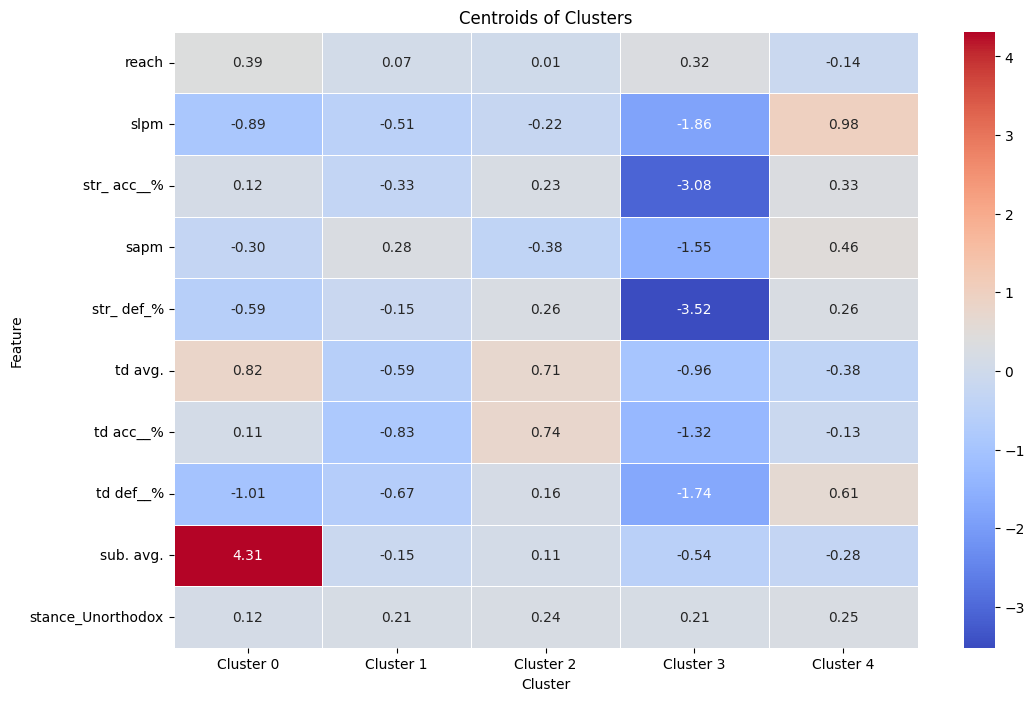

In [32]:
# Plot the centroids heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(centroids_df, cmap='coolwarm', annot=True, fmt=".2f", linewidths=.5)
plt.title('Centroids of Clusters')
plt.xlabel('Cluster')
plt.ylabel('Feature')
plt.show()

Based on the interpretations of the clusters, we can assign names to the fighter styles:

1. **Cluster 0: "Versatile Strikers"**
   - These fighters have a balanced approach to striking and grappling. They are adept at landing significant strikes, have decent takedown accuracy, and attempt submissions frequently. Their style is characterized by versatility in both striking and grappling exchanges.

2. **Cluster 1: "Counter Punchers"**
   - Fighters in this cluster rely on counter-striking techniques, waiting for their opponents to engage before delivering precise strikes. They have below-average striking output but are effective at defending takedowns. Their style emphasizes defensive skills and capitalizing on opponent mistakes.

3. **Cluster 2: "Technical Wrestlers"**
   - This cluster comprises fighters with strong wrestling backgrounds. They excel in takedowns and takedown defense, controlling the fight through grappling exchanges. Despite lower striking output, their technical grappling skills make them formidable opponents, especially in controlling the pace of the fight.

4. **Cluster 3: "Defensive Specialists"**
   - These fighters prioritize defensive tactics, relying on evasive maneuvers and defensive techniques to avoid significant strikes and takedowns. While their offensive output may be low, their ability to defend against strikes and takedowns allows them to frustrate opponents and capitalize on defensive lapses.

5. **Cluster 4: "Submission Artists"**
   - Fighters in this cluster are specialists in submission grappling, constantly seeking opportunities to secure submissions. While their striking output may be limited, they excel in grappling exchanges, frequently attempting submissions to finish fights. Their style emphasizes submission grappling and capitalizing on ground positions.

These names provide a brief description of each fighter style based on their performance metrics and characteristics within their respective clusters.